## Poisson equation
$-\frac{d^2 u}{dx^2} = f(x,w)$  
$u(-1) = u(1) = 0$  
$f(x,w) \sim GP(f_0(x), k(x,x'))$  
$f_0(x) = 10 \sin(\pi x)$  
$k(x,x') = \sigma^2 \exp\left(-\frac{(x-x')^2}{l^2}\right)$

Where:  
$\sigma = 1$ and $l = 0.5$

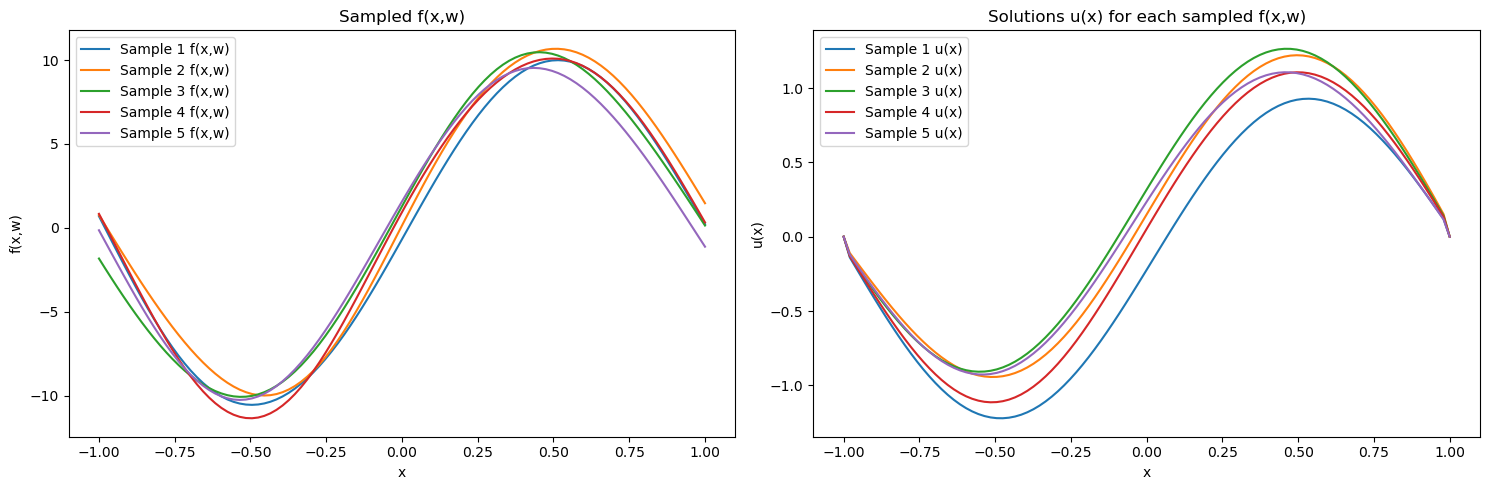

u[0] for each sample: [0. 0. 0. 0. 0.]
u[-1] for each sample: [0. 0. 0. 0. 0.]


In [92]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# Define parameters
sigma = 1
l = 0.5
n_points = 100
x = np.linspace(-1, 1, n_points)
dx = x[1] - x[0]

# Define the mean function and the kernel
f0 = lambda x: 10 * np.sin(np.pi * x)

def kernel(x, x_prime, sigma=sigma, l=l):
    return sigma**2 * np.exp(-((x-x_prime)**2) / l**2)

# Sample from the GP
def sample_GP(x, n_samples=1):
    mu = f0(x)
    K = np.array([[kernel(xi, xj) for xj in x] for xi in x])
    return np.random.multivariate_normal(mu, K, n_samples)

# Finite differences using scipy's sparse matrix to solve the Poisson equation

def solve_poisson(f, dx, u_left=0, u_right=0):
    N = len(f)
    diagonals = [-2 * np.ones(N), np.ones(N - 1), np.ones(N - 1)]
    A = diags(diagonals, [0, 1, -1], format="csr")
    A = A / dx**2

    # Set boundary conditions
    f[0] += u_left / dx**2
    f[-1] += u_right / dx**2

    u = spsolve(A, -f)
    u[0] = u[-1] = 0
    return u


n_samples = 5
f_samples = sample_GP(x, n_samples)
u_solutions = np.array([solve_poisson(f_sample, dx) for f_sample in f_samples])

plt.figure(figsize=(15, 5))

# Left subplot for f(x,w)
plt.subplot(1, 2, 1)
for i in range(n_samples):
    plt.plot(x, f_samples[i], label=f"Sample {i+1} f(x,w)")
plt.title("Sampled f(x,w)")
plt.xlabel('x')
plt.ylabel('f(x,w)')
plt.legend()

# Right subplot for u(x)
plt.subplot(1, 2, 2)
for i in range(n_samples):
    plt.plot(x, u_solutions[i], label=f"Sample {i+1} u(x)")
plt.title("Solutions u(x) for each sampled f(x,w)")
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

plt.tight_layout()
plt.show()

# Print u[0] and u[-1] for each sample

u_left_boundary = u_solutions[:, 0]
u_right_boundary = u_solutions[:, -1]

print(f"u[0] for each sample: {u_left_boundary}")
print(f"u[-1] for each sample: {u_right_boundary}")

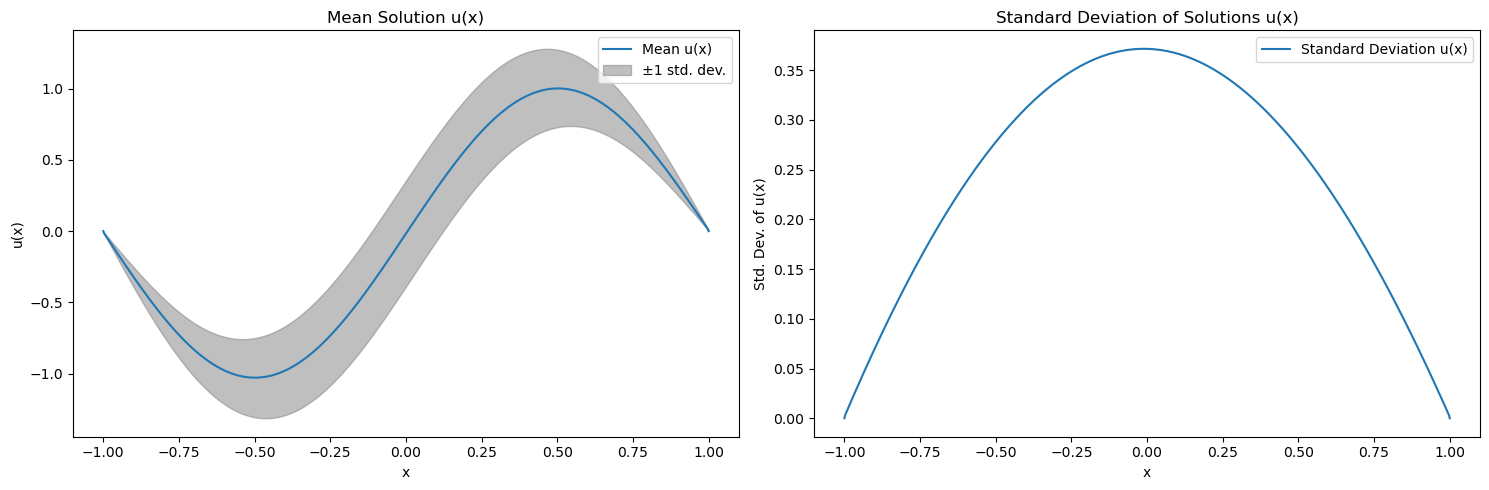

In [95]:
n_points = 1000
x = np.linspace(-1, 1, n_points)
dx = x[1] - x[0]

n_samples = 1000
f_samples = sample_GP(x, n_samples) # Matrix of shape (n_samples, n_points)
u_solutions = np.array([solve_poisson(f_sample, dx) for f_sample in f_samples]) # Matrix of shape (n_samples, n_points)

# Calculate the mean and standard deviation along the sample axis
u_mean = u_solutions.mean(axis=0)
u_std = u_solutions.std(axis=0)

# Plot the mean and standard deviation side by side
plt.figure(figsize=(15, 5))

# Left subplot for mean of u(x)
plt.subplot(1, 2, 1)
plt.plot(x, u_mean, label="Mean u(x)")
plt.fill_between(x, u_mean - u_std, u_mean + u_std, color='gray', alpha=0.5, label="±1 std. dev.")
plt.title("Mean Solution u(x)")
plt.xlabel('x')
plt.ylabel('u(x)')
plt.legend()

# Right subplot for standard deviation of u(x)
plt.subplot(1, 2, 2)
plt.plot(x, u_std, label="Standard Deviation u(x)")
plt.title("Standard Deviation of Solutions u(x)")
plt.xlabel('x')
plt.ylabel('Std. Dev. of u(x)')
plt.legend()

plt.tight_layout()
plt.show()

(array([   0.,    0.,    0.,    0.,    0., 1000.,    0.,    0.,    0.,
           0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

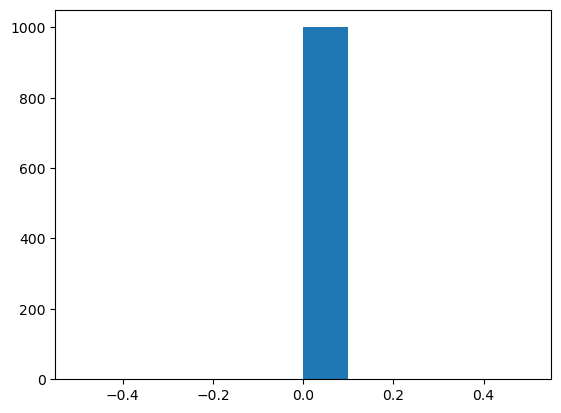

In [96]:
plt.hist(u_solutions[:,0])

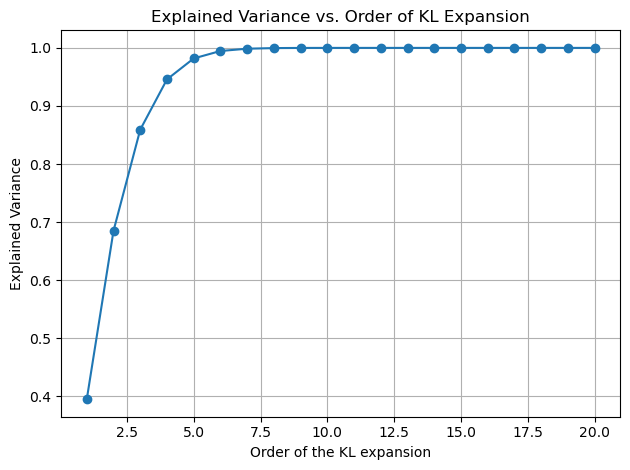

Truncation order for 99.0% explained variance: 6


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh

# Define the GP kernel
def kernel(x, x_prime, sigma=sigma, l=l):
    return sigma**2 * np.exp(-((x-x_prime)**2) / l**2)

# Compute the covariance matrix for the grid points
K = np.array([[kernel(xi, xj) for xj in x] for xi in x])

# Compute the eigenvalues and eigenvectors of the covariance matrix
eigenvalues, eigenvectors = eigh(K)

# Sort eigenvalues in decreasing order and their associated eigenvectors
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:, idx]

# Compute the cumulative explained variance
explained_variance = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Plot explained variance
plt.figure()
n_orders = 20
plt.plot(np.arange(1, n_orders + 1), explained_variance[:n_orders], marker='o')
plt.xlabel('Order of the KL expansion')
plt.ylabel('Explained Variance')
plt.title('Explained Variance vs. Order of KL Expansion')
plt.grid(True)
plt.tight_layout()
plt.show()

# Propose truncation order based on a threshold
threshold = 0.99  # Example threshold for 95% explained variance
truncation_order = np.argmax(explained_variance >= threshold) + 1
print(f"Truncation order for {threshold*100}% explained variance: {truncation_order}")


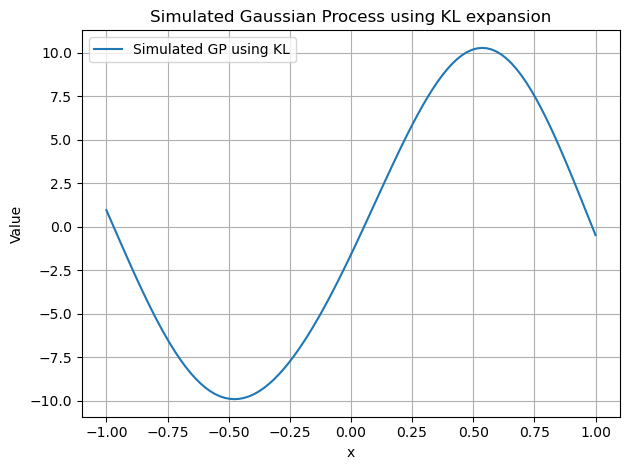

In [4]:
def simulate_gp_with_kl(x, eigenvectors, eigenvalues, truncation_order):
    """Simulate the Gaussian Process using the KL expansion."""
    # Generate standard normal random variables
    xi = np.random.randn(truncation_order)
    
    # KL expansion
    kl_terms = np.sqrt(eigenvalues[:truncation_order]) * xi @ eigenvectors[:, :truncation_order].T
    return f0(x) + kl_terms

# Simulate the GP using the KL expansion
simulated_gp = simulate_gp_with_kl(x, eigenvectors, eigenvalues, truncation_order)

plt.figure()
plt.plot(x, simulated_gp, label='Simulated GP using KL')
plt.xlabel('x')
plt.ylabel('Value')
plt.title('Simulated Gaussian Process using KL expansion')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim

# Ensure reproducibility
torch.manual_seed(0)

# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu"
def grad_i(Y,X,i):
    #calculate the partial derivative of y with respect to x_i
    return torch.autograd.grad(Y, X, grad_outputs=torch.ones_like(Y), create_graph=True)[0][:, None, i]
print("Using GPU:", torch.cuda.is_available())

Using GPU: True


In [56]:
def hermite_polynomial(order, xi):
    """Compute the Hermite polynomial of a given order for xi."""
    if order == 0:
        return torch.ones_like(xi)
    elif order == 1:
        return xi
    else:
        H0 = torch.ones_like(xi)
        H1 = xi
        for _ in range(2, order + 1):
            H_next = xi * H1 - (order - 1) * H0
            H0, H1 = H1, H_next
        return H1

def generate_pce_basis(xi, max_order):
    """Generate PCE basis up to a given order for xi."""
    basis = []
    for order in range(max_order + 1):
        basis.append(hermite_polynomial(order, xi))
    return torch.stack(basis, dim=-1)

class MeanNN(nn.Module):
    """Neural network to approximate the mean function."""
    def __init__(self, input_dim, hidden_dim=4):
        super(MeanNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x


class PCECoefficientNN(nn.Module):
    """Neural network to approximate the coefficients of the PCE."""
    def __init__(self, input_dim, hidden_dim=32, output_dim=None):
        super(PCECoefficientNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

def f_from_xi(xi, x_train):
    xi = xi.detach().cpu().numpy()
    x_train = x_train.detach().cpu().numpy()
    f_stoch = np.sqrt(eigenvalues[:truncation_order]) * xi @ eigenvectors[:, :truncation_order].T
    f = f0(x_train) + [f_stoch[int(i)] for i in np.linspace(0, len(f_stoch)-1, len(x_train))]
    return torch.tensor(f).to(device)

def l2_regularization(model, lambda_reg=1e-3):
    l2_reg = None
    for W in model.parameters():
        if l2_reg is None:
            l2_reg = W.norm(2)
        else:
            l2_reg = l2_reg + W.norm(2)
    return lambda_reg * l2_reg
    
def compute_loss(x, xi, mean_model, coeffs_model, batch_size):

    indices = torch.randperm(xi.size(0))[:batch_size]
    xi_batch = xi[indices]
    loss = 0
    for i in range(batch_size):
        xi_sample = xi_batch[i, :]
        f = f_from_xi(xi_sample, x)
        # Compute the PCE basis
        pce_basis = hermite_polynomial(1, xi_sample)

        # Total predicted u
        u_predicted = mean_model(x).flatten() + coeffs_model(x) @ pce_basis.T
        # 1st derivative of u wrt x
        du_dx = grad_i(u_predicted, x, 0)        
        # 2nd derivative of u wrt x (Laplacian in 1D)
        d2u_dx2 = grad_i(du_dx, x, 0)
    
    
        # PDE Residual Loss: -d^2u/dx^2 - f(x, w)
        pde_residual = d2u_dx2 + f
        pde_loss = torch.mean(pde_residual**2) / len(x)

        # # Boundary Conditions Loss
        bc_loss_left = u_predicted[0]**2
        bc_loss_right = u_predicted[-1]**2
        bc_loss = (bc_loss_left + bc_loss_right) / 2

        # Combine the losses
        loss += pde_loss + bc_loss
    
    loss = loss / batch_size 
    return loss

In [57]:
n_sensors = 13

xi_train = torch.randn((1000, truncation_order)).to(device)  # 1000 samples, `truncation_order` random variables
x_train = torch.linspace(-1, 1, n_sensors).unsqueeze(-1).to(device)  # Corresponding x values
x_train.requires_grad = True

# Models, Loss, and Optimizer
mean_model = MeanNN(input_dim=1).to(device)
coeffs_model = PCECoefficientNN(input_dim=1, output_dim=truncation_order).to(device)
optimizer = optim.Adam(list(mean_model.parameters()) + list(coeffs_model.parameters()), lr=1e-3)


In [72]:
def train(mean_model, coeffs_model, batch_size=100, optimizer_choice="adam", epochs=1000, lr=0.001, lambda_reg=1e-4):
    if optimizer_choice == "adam":
        optimizer = torch.optim.Adam(list(mean_model.parameters()) + list(coeffs_model.parameters()), lr=lr)
        for epoch in range(epochs):
            optimizer.zero_grad()
            
            mean_output = mean_model(x_train)
            coeffs_output = coeffs_model(x_train)
            
            loss = compute_loss(x_train, xi_train, mean_model, coeffs_model, batch_size)
            l2_reg = l2_regularization(mean_model) + l2_regularization(coeffs_model,lambda_reg)
            loss += l2_reg
            loss.backward()
            optimizer.step()
            
            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item()}")
                
    elif optimizer_choice == "l-bfgs":
        optimizer = torch.optim.LBFGS(list(mean_model.parameters()) + list(coeffs_model.parameters()), lr=lr, max_iter=20, history_size=100)

        for epoch in range(epochs):
            def closure():
                optimizer.zero_grad()
                mean_output = mean_model(x_train)
                coeffs_output = coeffs_model(x_train)
                
                loss = compute_loss(x_train, xi_train, mean_model, coeffs_model, batch_size)
                l2_reg = l2_regularization(mean_model) + l2_regularization(coeffs_model,lambda_reg)
                loss += l2_reg
                loss.backward()
                return loss

            optimizer.step(closure)
            
            # Print progress
            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {closure().item()}")
    else:
        print(f"Optimizer choice {optimizer_choice} not recognized. Please choose either 'adam' or 'l-bfgs'.")

Epoch [1/100], Loss: 0.063626
Epoch [11/100], Loss: 0.063624
Epoch [21/100], Loss: 0.063621
Epoch [31/100], Loss: 0.063618
Epoch [41/100], Loss: 0.063615
Epoch [51/100], Loss: 0.063613
Epoch [61/100], Loss: 0.063610
Epoch [71/100], Loss: 0.063607
Epoch [81/100], Loss: 0.063605
Epoch [91/100], Loss: 0.063602


In [ ]:
# Example usage:
batch_size = 100
lambda_reg = 1e-4
epochs = 1000

train(mean_model, coeffs_model, batch_size=batch_size, optimizer_choice="adam", epochs=10000, lr=0.001, lambda_reg=lambda_reg)
# train(mean_model, coeffs_model, batch_size=100, optimizer_choice="l-bfgs", epochs=epochs, lambda_reg=lambda_reg)

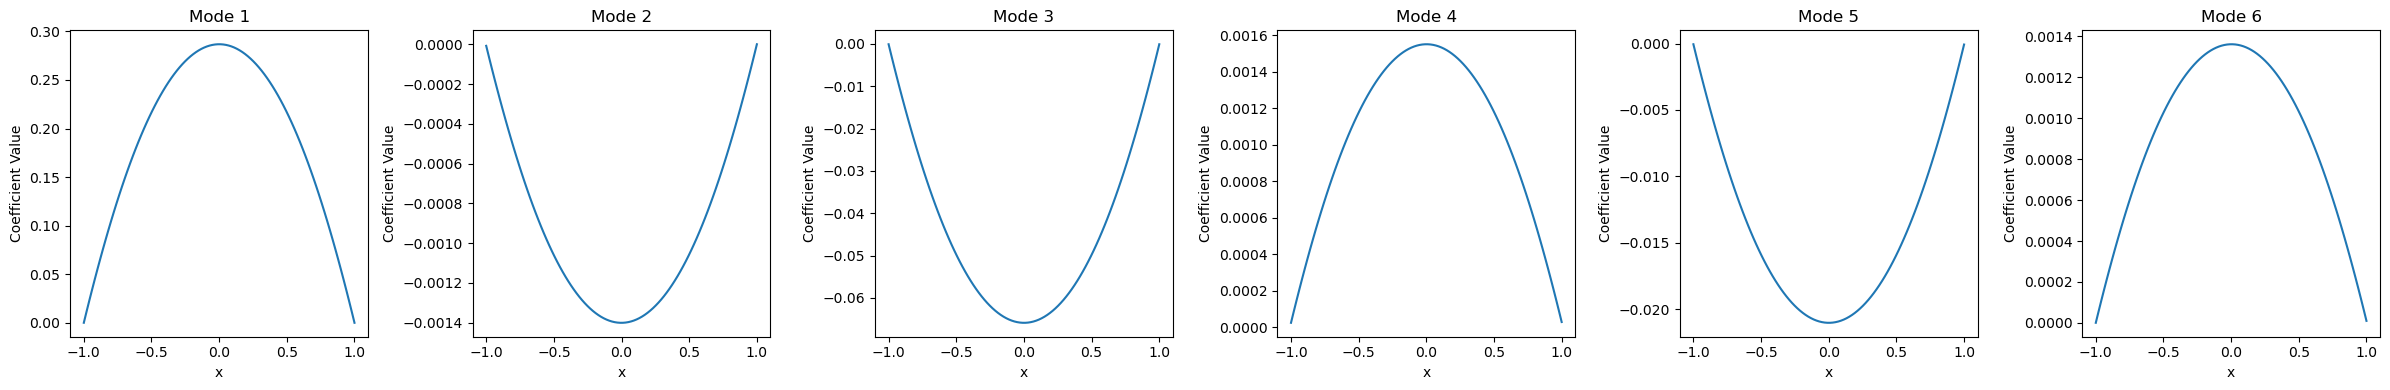

In [73]:
def plot_modes(x_values, modes_to_plot):
    # Convert x_values to a PyTorch tensor
    x_tensor = torch.tensor(x_values, dtype=torch.float32).view(-1, 1)
    
    # Evaluate the model (turn off gradient computation for evaluation)
    with torch.no_grad():
        coeffs_output = coeffs_model(x_tensor)

    # Convert the outputs back to numpy for plotting
    coeffs_numpy = coeffs_output.numpy()

    # Number of modes to plot
    num_modes = len(modes_to_plot)
    
    # Create subplots for each mode
    fig, axs = plt.subplots(1, num_modes, figsize=(4*num_modes, 4))
    
    for i, mode in enumerate(modes_to_plot):
        if num_modes > 1:
            ax = axs[i]
        else:
            ax = axs
        ax.plot(x_values, coeffs_numpy[:, mode-1], label=f"Mode {mode}")
        ax.set_title(f"Mode {mode}")
        ax.set_xlabel('x')
        ax.set_ylabel('Coefficient Value')
    
    plt.tight_layout()
    plt.show()

# Define the inputs and modes you want to visualize
x_values = np.linspace(-1, 1, 100)
modes_to_plot = [1,2,3,4,5, 6]  # For example, if you want to plot the first three modes. Adjust this as needed.

plot_modes(x_values, modes_to_plot)

Text(0.5, 1.0, 'Comparison of Exact and Predicted Standard Deviations')

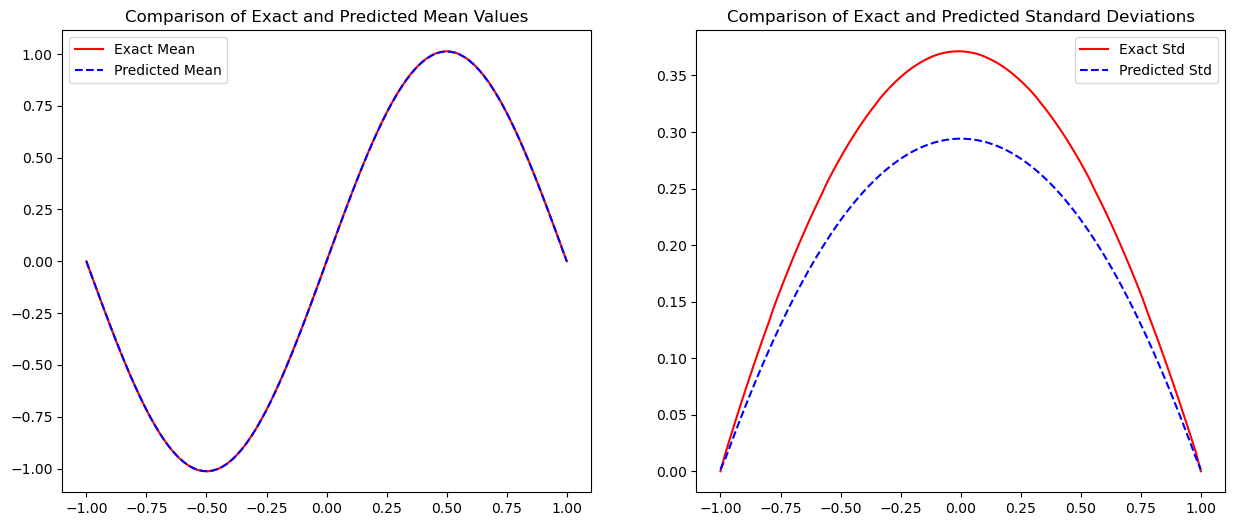

In [99]:
subsample_ind = [int(i) for i in np.linspace(0,len(u_std)-1,100)]
x_values = np.linspace(-1, 1, 100)
x_tensor = torch.tensor(x_values).float().view(-1, 1)

u_mean = f0(x_values)/np.pi**2

# Evaluate the mean_model to get the predicted mean values
with torch.no_grad():
    predicted_mean = mean_model(x_tensor).numpy()
    coeffs_output = coeffs_model(x_tensor).numpy()

model_std = np.sqrt(np.sum(coeffs_numpy**2, axis=1))

# Plot the comparison
fig, axs = plt.subplots(1,2,figsize=(15, 6))
axs[0].plot(x_values, u_mean, 'r-', label="Exact Mean")
axs[0].plot(x_values, predicted_mean, 'b--', label="Predicted Mean")
axs[0].legend()
axs[0].set_title('Comparison of Exact and Predicted Mean Values')

axs[1].plot(x_values, u_std[subsample_ind], 'r-', label="Exact Std")
axs[1].plot(x_values, model_std, 'b--', label="Predicted Std")
axs[1].legend()
axs[1].set_title('Comparison of Exact and Predicted Standard Deviations')
